# Compute error generated from the model used to fit the patterns


- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 27th 2020
- update date :


Study the relative atmosphere relative to an ideal profile in **libradtran/info_verbose/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT**
- no aerosol
- pwv =4 mm
- ozone = 3000 DU
- No extinction coefficient
- airmass = 1


Fit components:

- h2o,
- o2,
- o3




In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import sys
%matplotlib inline

In [5]:
from astropy.io import fits

In [6]:
from pprint import pprint # we use this to pretty print some stuff later

In [7]:
from datetime import datetime,date
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [82]:
#to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [9]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [10]:
import timeit

In [26]:
import pysynphot as S
#from scipy.interpolate import interp1d
import astropy.units as u
from astropy import constants as const
#from astropy.io import fits

In [12]:
PATH_LSSTFiltersKG='../data/lsst/LSSTFiltersKG'

sys.path.append(PATH_LSSTFiltersKG)

import libLSSTFiltersKG as lsst

liblsstfilter_path= ../data/lsst/LSSTFiltersKG


In [13]:
%load_ext autoreload
%autoreload 2

# Configuration

In [28]:
##----
NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0                      # LSST Exposure time

#------------------------------------------------------------------------------------------
#  Compute the multiplicative factor as calcilated for SpectractorSim to be used for AuxTel
#-------------------------------------------------------------------------------------------
Tel_Surf=LSST_COLL_SURF*(u.cm)**2            # collection surface of telescope
Time_unit=1*u.s                              # flux for 1 second
SED_unit=1*u.erg/u.s/(u.cm)**2/(u.nanometer) # Units of SEDs in flam (erg/s/cm2/nm)
hc=const.h*const.c                           # h.c product of fontamental constants c and h 
wl_dwl_unit=(u.nanometer)**2                 # lambda.dlambda  in wavelength in nm
g_elec=3.0                                   # electronic gain : elec/ADU
g_disperser_ronchi=0.2                       # theoretical gain for order+1 : 20%
#Factor=2.1350444e11
Factor=(Tel_Surf*SED_unit*Time_unit*wl_dwl_unit/hc/g_elec*g_disperser_ronchi).decompose()
#-------------------------------------------------------------------------------------------------

graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
      area: 350000.0
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


## atmospheric data file

In [14]:
input_datafile="lsst_atm_10year_fittedabspatternsandsims.fits"

# Source

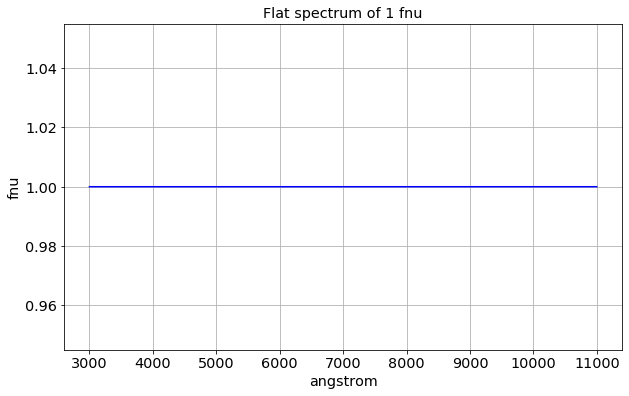

In [32]:
# 1) get a typical spectrum in Fnu unit (erg/sec/Hz/cm2)
#-----------------------------------------------------
plt.figure()
flatsp = S.FlatSpectrum(3631, fluxunits='fnu')
plt.plot(flatsp.wave, flatsp.flux,'b-')
plt.xlabel(flatsp.waveunits)
plt.ylabel(flatsp.fluxunits)
plt.title(flatsp.name)
plt.grid()
plt.show()
    

# Read Filters

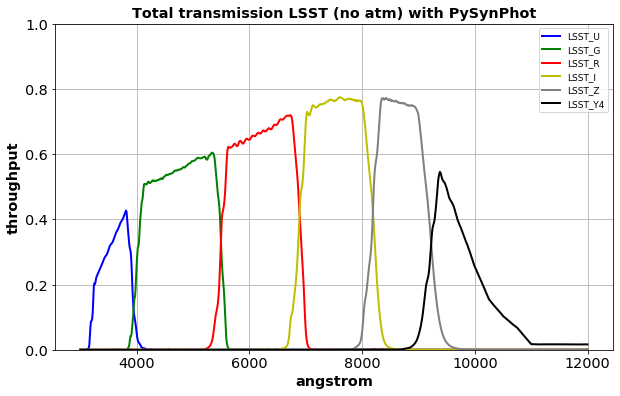

In [29]:
#  2) Read LSST passband in Angstrom
#-------------------------------------------------------
bp_u,bp_g,bp_r,bp_i,bp_z,bp_y=lsst.GetAllLSSTBands("../data/lsst")
lsst.PlotAllLSSTBands(bp_u,bp_g,bp_r,bp_i,bp_z,bp_y)

# Read Atmospheric File

In [15]:
hdu = fits.open(input_datafile)

In [16]:
hdu.info()

Filename: lsst_atm_10year_fittedabspatternsandsims.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      33   (1583, 3652)   float64   


## Header

In [17]:
hdr=hdu[0].header

In [18]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1583                                                  
NAXIS2  =                 3652                                                  
NBSIM   =                 3650                                                  
NPARAMS =                   15                                                  
NWL     =                  782                                                  
PFITPAR =                    0                                                  
PAR_H2O =                    0                                                  
PAR_O2  =                    1                                                  
PAR_O3  =                    2                                                  
PAR_A0  =                   

### decode the header

In [19]:
NBSIM   = hdr["NBSIM "]
NWL     = hdr["NWL"] 
DATAFIT = hdr["DATAFIT"]
DATASIM = hdr["DATASIM"]
DATAEND = hdr["DATAEND"]

In [20]:
# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSIM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSIM), alpha=1)

## Data

In [21]:
data=hdu[0].data

In [22]:
#plt.imshow(data,origin="lower",vmin=0.9,vmax=0.96)

In [38]:
WL=data[0,DATAFIT:DATAFIT+NWL]
TRANSM0= data[1,DATASIM:DATASIM+NWL]  # reference transmission profile (no aerosol, pwv=4, o3=300)

# Plot the differences

Text(0, 0.5, 'magnitude')

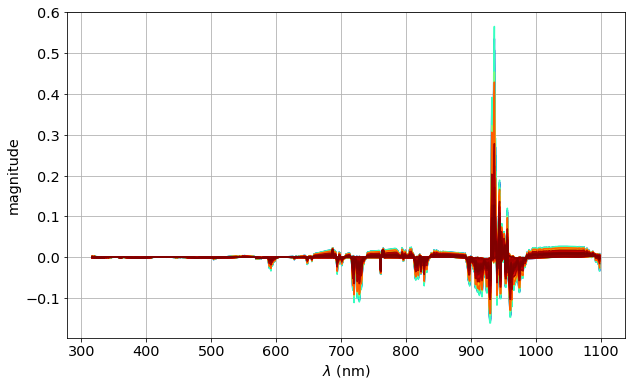

In [24]:
IDXMAX=int(NBSIM/10)

# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=IDXMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(IDXMAX), alpha=1)

for IDX in np.arange(IDXMAX):
    fitprofile  = data[IDX+2,DATAFIT:DATAFIT+NWL]
    simprofile  = data[IDX+2,DATASIM:DATASIM+NWL]
    diffmag=-2.5*np.log10(fitprofile/simprofile)
    plt.plot(WL,diffmag,"-",color=all_colors[IDX])
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("magnitude")

Text(0, 0.5, 'difference in relative profile')

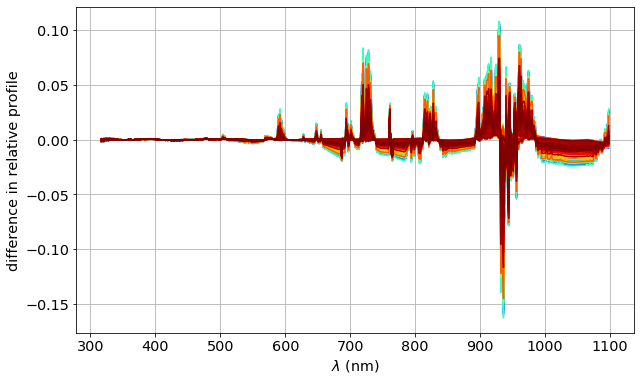

In [25]:
IDXMAX=int(NBSIM/10)

# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=IDXMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(IDXMAX), alpha=1)

for IDX in np.arange(IDXMAX):
    fitprofile  = data[IDX+2,DATAFIT:DATAFIT+NWL]
    simprofile  = data[IDX+2,DATASIM:DATASIM+NWL]
    diffprofile = fitprofile - simprofile
    plt.plot(WL,diffprofile,"-",color=all_colors[IDX])
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("difference in relative profile")

# Compute magnitude difference in each band

In [71]:
def ComputeObservation(bandpass,IDXMAX):
    """
    """

    global data
    
    # container
    all_obs_fit=[]
    all_obs_sim=[]

    all_count_fit=[]
    all_count_sim=[]
    
    all_mag_ratio=[]

    for IDX in np.arange(IDXMAX):
       
        fitatmprofile  = data[IDX+2,DATAFIT:DATAFIT+NWL]*TRANSM0
        simatmprofile  = data[IDX+2,DATASIM:DATASIM+NWL]*TRANSM0
    
        # create the passband
        bp_atm_fit=S.ArrayBandpass(WL*10,  fitatmprofile , name='fit_atm_transm')*bandpass
        bp_atm_sim=S.ArrayBandpass(WL*10,  simatmprofile, name='sim_atm_transm')*bandpass
    
        # create the observation
        obs_fit = S.Observation(flatsp, bp_atm_fit);
        obs_sim = S.Observation(flatsp, bp_atm_sim);
    
        count_fit=obs_fit.countrate()
        count_sim=obs_sim.countrate()
        mag_ratio = -2.5*np.log10(count_fit/count_sim)
   
        all_obs_fit.append(obs_fit)
        all_obs_sim.append(obs_sim)
    
        all_count_fit.append(count_fit)
        all_count_sim.append(count_sim)
        
        all_mag_ratio.append(mag_ratio )
        
    return all_obs_fit, all_obs_sim, np.array(all_count_fit), np.array(all_count_sim), np.array(all_mag_ratio)

In [55]:
IDXMAX=int(NBSIM/10)

In [61]:
IDXMAX

365

In [72]:
all_obs_fit_Y, all_obs_sim_Y, all_count_fit_Y, all_count_sim_Y, all_mag_ratio_Y = ComputeObservation(bp_y,IDXMAX)

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Y4)) does not have a defined binset in the wavecat t

In [77]:
all_obs_fit_Z, all_obs_sim_Z, all_count_fit_Z, all_count_sim_Z, all_mag_ratio_Z = ComputeObservation(bp_z,IDXMAX)

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_Z)) does not have a defined binset in the wavecat table. Th

In [78]:
all_obs_fit_I, all_obs_sim_I, all_count_fit_I, all_count_sim_I, all_mag_ratio_I = ComputeObservation(bp_i,IDXMAX)

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_I)) does not have a defined binset in the wavecat table. Th

In [79]:
all_obs_fit_R, all_obs_sim_R, all_count_fit_R, all_count_sim_R, all_mag_ratio_R = ComputeObservation(bp_r,IDXMAX)

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_R)) does not have a defined binset in the wavecat table. Th

In [80]:
all_obs_fit_G, all_obs_sim_G, all_count_fit_G, all_count_sim_G, all_mag_ratio_G = ComputeObservation(bp_g,IDXMAX)

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_G)) does not have a defined binset in the wavecat table. Th

In [81]:
all_obs_fit_U, all_obs_sim_U, all_count_fit_U, all_count_sim_U, all_mag_ratio_U = ComputeObservation(bp_u,IDXMAX)

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((fit_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((sim_atm_transm * LSST_U)) does not have a defined binset in the wavecat table. Th

Text(0.5, 1.0, 'Simulated observation')

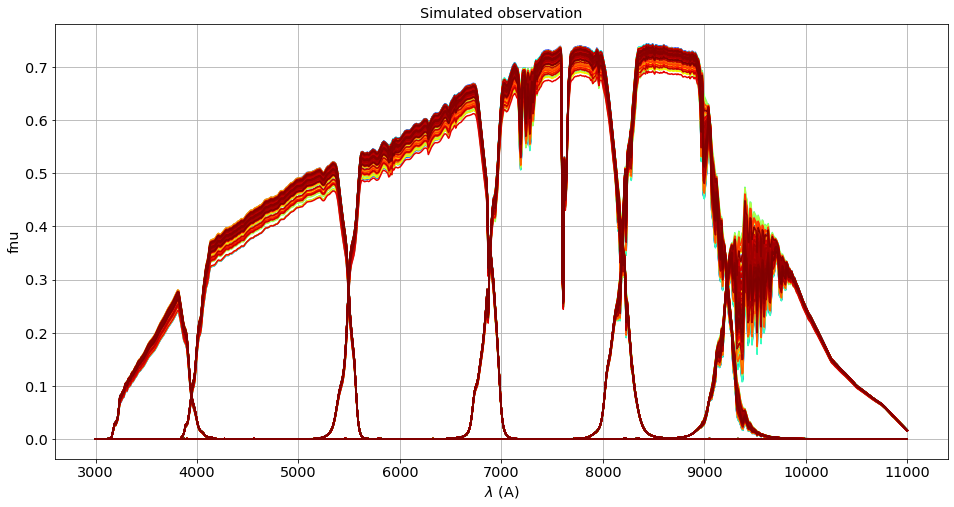

In [100]:
# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=IDXMAX)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(IDXMAX), alpha=1)

plt.figure(figsize=(16,8))
for IDX in np.arange(IDXMAX):  
    plt.plot(all_obs_sim_Y[IDX].binwave,all_obs_sim_Y[IDX].binflux,"-",color=all_colors[IDX])
    plt.plot(all_obs_sim_Z[IDX].binwave,all_obs_sim_Z[IDX].binflux,"-",color=all_colors[IDX])
    plt.plot(all_obs_sim_I[IDX].binwave,all_obs_sim_I[IDX].binflux,"-",color=all_colors[IDX])
    plt.plot(all_obs_sim_R[IDX].binwave,all_obs_sim_R[IDX].binflux,"-",color=all_colors[IDX])
    plt.plot(all_obs_sim_G[IDX].binwave,all_obs_sim_G[IDX].binflux,"-",color=all_colors[IDX])
    plt.plot(all_obs_sim_U[IDX].binwave,all_obs_sim_U[IDX].binflux,"-",color=all_colors[IDX])
    plt.grid()
    plt.xlabel("$\lambda$ (A)")
    plt.ylabel(all_obs_sim_Y[IDX].fluxunits)
plt.title("Simulated observation")

Text(0.5, 1.0, 'Magnitude bias with the template fit method')

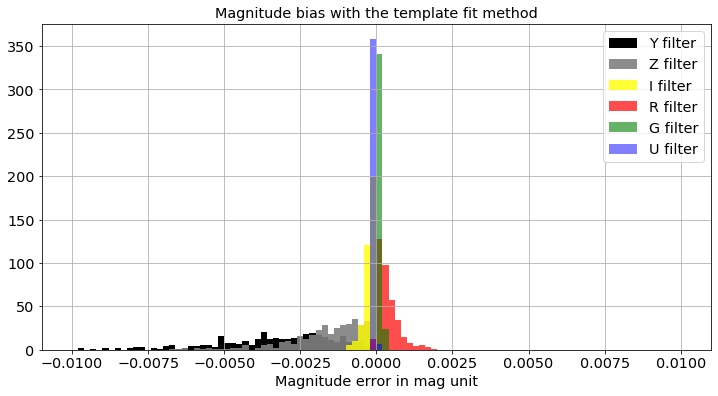

In [97]:
plt.figure(figsize=(12,6))
plt.hist(all_mag_ratio_Y,bins=100,range=(-0.01,0.01),facecolor="k",alpha=1.0,label="Y filter");
plt.hist(all_mag_ratio_Z,bins=100,range=(-0.01,0.01),facecolor="grey",alpha=0.9,label="Z filter");
plt.hist(all_mag_ratio_I,bins=100,range=(-0.01,0.01),facecolor="yellow",alpha=0.8,label="I filter");
plt.hist(all_mag_ratio_R,bins=100,range=(-0.01,0.01),facecolor="red",alpha=0.7,label="R filter");
plt.hist(all_mag_ratio_G,bins=100,range=(-0.01,0.01),facecolor="green",alpha=0.6,label="G filter");
plt.hist(all_mag_ratio_U,bins=100,range=(-0.01,0.01),facecolor="blue",alpha=0.5,label="U filter");
plt.grid()
plt.xlabel("Magnitude error in mag unit")
plt.legend()
plt.title("Magnitude bias with the template fit method")